In [7]:
from matplotlib import pylab as plt

import os
import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj

In [8]:
RASCAL_PATH = "/Users/matthiaskellner/Desktop/EPFL_2021/python_packages/librascal/examples/i-PI/zundel" #TODO: change to relative path?


In [9]:
N_dataset = 1000
frames = read(os.path.join(RASCAL_PATH, 'zundel_dataset.xyz'), index=':{}'.format(N_dataset))
energies = np.loadtxt(os.path.join(RASCAL_PATH, 'zundel_energies.txt'))[:N_dataset]

#Keys of the arrays dictionary
print(frames[0].arrays.keys())


dict_keys(['numbers', 'positions', 'forces'])


In [10]:
def extract_forces(frames,array_key='zeros'):
    f = []
    for frame in frames:
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    try:
        f = np.concatenate(f)
    except:
        pass
    return f

In [11]:
n = 800

global_species = set()
for frame in frames:
    global_species.update(frame.get_atomic_numbers())
global_species = np.array(list(global_species))

# Select randomly n structures for training the model
ids = list(range(N_dataset))
np.random.seed(10)
np.random.shuffle(ids)

train_ids = ids[:n]
frames_train = [frames[ii] for ii in ids[:n]]
y_train = [energies[ii] for ii in ids[:n]]
y_train = np.array(y_train)

In [12]:
y_train.shape

(800,)

In [13]:
f_train = extract_forces(frames_train, 'forces')
f = extract_forces(frames, 'forces')

In [14]:
# Atomic energy baseline
atom_energy_baseline = np.mean(energies)/(frames[0].get_global_number_of_atoms())
energy_baseline = {int(species): atom_energy_baseline for species in global_species}


In [15]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.0,
              max_radial=8,
              max_angular=6,
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=3.5,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False
              )


soap = SphericalInvariants(**hypers)


In [16]:
managers = []
for f in tqdm(frames_train):
    f.wrap(eps=1e-18)

start = time()
managers = soap.transform(frames_train)
print ("Execution: ", time()-start, "s")




Execution:  0.48047375679016113 s


In [17]:
n_sparse = {1:50, 8:100}
compressor = CURFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers)

In [18]:
zeta = 2

start = time()
hypers['compute_gradients'] = True
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = compute_KNM(tqdm(frames_train, leave=True, desc="Computing kernel matrix"), X_sparse, kernel, soap)

model = train_gap_model(kernel, frames_train, KNM, X_sparse, y_train, energy_baseline,
                        grad_train=-f_train, lambdas=[1e-12, 1e-12], jitter=1e-13)

# save the model to a file in json format for future use
dump_obj('zundel_model.json', model)
np.savetxt('Structure_indices.txt', ids)
print ("Execution: ", time()-start, "s")



Execution:  6.71238899230957 s


In [19]:
n = 800
model = load_obj('zundel_model.json')
ids = np.loadtxt('Structure_indices.txt')

In [20]:
train_ids = [int(i) for i in ids[:n]]
test_ids = [int(i) for i in ids[n:]]

frames_train = [frames[ii] for ii in train_ids]
frames_test = [frames[ii] for ii in test_ids]

y_train = [energies[ii] for ii in train_ids]
y_train = np.array(y_train)
y_test = [energies[ii] for ii in test_ids]
y_test = np.array(y_test)

In [21]:
y_pred = []
f_pred = []

for f in tqdm(frames_test):
    positions = f.get_positions()
    f.set_positions(positions+[1,1,1])
    f.wrap(eps=1e-18)
    m = soap.transform(f)
    y_pred.append(model.predict(m))
    f_pred.append(model.predict_forces(m))

y_pred = np.array(y_pred).flatten()
f_pred = np.array(f_pred)


In [22]:
f_test = extract_forces(frames_test, 'forces')

In [23]:
from rascal.utils import get_score

score = get_score(y_pred, y_test)
RMSE = score['RMSE']
sigma_test = np.std(y_test)
print("RMSE = ", RMSE*1000.0, "meV")
print("Sigma test set = ", sigma_test, " eV")
print("%RMSE = ", RMSE/sigma_test*100.0, " %")

RMSE =  32.9073264153478 meV
Sigma test set =  0.274800153468654  eV
%RMSE =  11.975002924844249  %


Text(0, 0.5, 'reference energies [eV]')

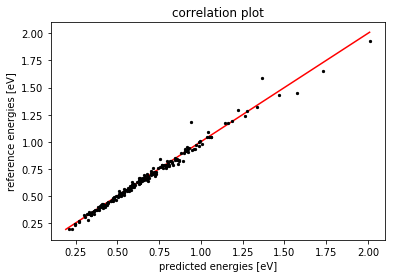

In [24]:
plt.scatter(y_test, y_pred, s=5.0, c = 'black')
lims = [
    np.min([np.min(y_pred), np.min(y_test)]),  # min of both axes
    np.max([np.max(y_pred), np.max(y_test)]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', zorder=0, color='red')
plt.title("correlation plot")
plt.xlabel("predicted energies [eV]")
plt.ylabel("reference energies [eV]")